In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import math
import keras
import tensorflow as tf

from bayesflow.experimental import AmortizedPosteriorLikelihood, AmortizedPosterior, AmortizedLikelihood
from bayesflow.experimental import GenerativeModel, OfflineDataset, OnlineDataset

2024-03-11 15:09:47.262003: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 15:09:47.839862: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()

In [4]:
class ContextPrior:
    def sample_contexts(self, batch_shape):
        r = tf.random.normal(batch_shape + (1,), mean=0.1, stddev=0.01)
        alpha = tf.random.uniform(batch_shape + (1,), minval=-math.pi / 2.0, maxval=math.pi / 2.0)

        return {"r": r, "alpha": alpha}

In [5]:
class ParameterPrior:
    def sample_parameters(self, batch_shape, contexts=None):
        theta1 = tf.random.uniform(batch_shape + (1,), minval=-1.0, maxval=1.0)
        theta2 = tf.random.uniform(batch_shape + (1,), minval=-1.0, maxval=1.0)

        return {"theta1": theta1, "theta2": theta2}

In [6]:
class Simulator:
    def sample_observables(self, batch_shape, parameters, contexts=None):
        theta1, theta2 = parameters["theta1"], parameters["theta2"]
        r, alpha = contexts["r"], contexts["alpha"]

        x1 = -tf.abs(theta1 + theta2) / tf.sqrt(2.0) + r * tf.cos(alpha) + 0.25
        x2 = (-theta1 + theta2) / tf.sqrt(2.0) + r * tf.sin(alpha)

        return {"x1": x1, "x2": x2}

In [7]:
class InferenceNetwork(keras.Model):
    """ Simple Implementation of Flow Matching without Optimal Transport as the Inference Network """
    def __init__(self):
        super().__init__()
        self.fc = keras.Sequential([
            keras.layers.Input((2 + 1 + 2,)),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dense(2),
        ])
    
    def sample(self, batch_shape, data=None, steps=100):
        x = tf.random.normal(batch_shape + (2,))
        t = tf.zeros(batch_shape + (1,))
        c = tf.concat([data["observables"]["x1"], data["observables"]["x2"]], axis=1)
        dt = 1.0 / steps
        
        for step in range(steps):
            v = self.fc(tf.concat([x, t, c], axis=1))
            
            x += v * dt
            t += dt
        
        return x
    
    def compute_loss(self, data=None, *args, **kwargs):
        x1 = tf.concat([data["parameters"]["theta1"], data["parameters"]["theta2"]], axis=1)        
        c = tf.concat([data["observables"]["x1"], data["observables"]["x2"]], axis=1)

        x0 = tf.random.normal(tf.shape(x1))
        t = tf.random.uniform((tf.shape(x1)[0], 1))
        x = t * x1 + (1 - t) * x0
        xtc = tf.concat([x, t, c], axis=1)

        target_velocity = x1 - x0
        predicted_velocity = self.fc(xtc)

        return keras.losses.mean_squared_error(target_velocity, predicted_velocity)

    def compute_metrics(self, *args, **kwargs):
        return {}

In [8]:
class SurrogateNetwork(keras.Model):
    def __init__(self):
        super().__init__()
        self.fc = keras.Sequential([
            keras.layers.Input((2 + 1 + 4,)),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dense(2),
        ])

    def sample(self, batch_shape, data=None, steps=100):
        x = tf.random.normal(batch_shape + (2,))
        t = tf.zeros(batch_shape + (1,))
        dt = 1.0 / steps
        
        parameters = tf.concat([data["parameters"]["theta1"], data["parameters"]["theta2"]], axis=1)
        contexts = tf.concat([data["contexts"]["r"], data["contexts"]["alpha"]], axis=1)
        c = tf.concat([parameters, contexts], axis=1)
        
        for step in range(steps):
            v = self.fc(tf.concat([x, t, c], axis=1))
            
            x += v * dt
            t += dt
        
        return x

    def compute_loss(self, data=None, *args, **kwargs):
        contexts = tf.concat([data["contexts"]["r"], data["contexts"]["alpha"]], axis=1)
        parameters = tf.concat([data["parameters"]["theta1"], data["parameters"]["theta2"]], axis=1)
        c = tf.concat([parameters, contexts], axis=1)
        
        x1 = tf.concat([data["observables"]["x1"], data["observables"]["x2"]], axis=1)
        x0 = tf.random.normal(tf.shape(x1))
        t = tf.random.uniform((tf.shape(x1)[0], 1))
        x = t * x1 + (1 - t) * x0
        xtc = tf.concat([x, t, c], axis=1)
        
        target_velocity = x1 - x0
        predicted_velocity = self.fc(xtc)
        
        return keras.losses.mean_squared_error(target_velocity, predicted_velocity)

    def compute_metrics(self, *args, **kwargs):
        return {}

In [9]:
context_prior = ContextPrior()
parameter_prior = ParameterPrior()
simulator = Simulator()

In [10]:
generative_model = GenerativeModel(parameter_prior, simulator, context_prior)

In [11]:
model = AmortizedPosteriorLikelihood(
    summary_network=None,
    inference_network=InferenceNetwork(),
    surrogate_network=SurrogateNetwork()
)

I0000 00:00:1710166188.535802  162277 cuda_executor.cc:1035] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-11 15:09:48.537114: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2257] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
epochs = 100
batch_size = 256
batches_per_epoch = 128
warmup_steps = int(0.3 * epochs * batches_per_epoch)
decay_steps = epochs * batches_per_epoch - warmup_steps
lr_scheduler = keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-4, warmup_target=1e-3, alpha=1e-6, warmup_steps=warmup_steps, decay_steps=decay_steps)
optimizer = keras.optimizers.Adam(learning_rate=lr_scheduler, clipnorm=1.0)

model.compile(optimizer=optimizer)

In [13]:
dataset = OnlineDataset(generative_model, batch_size=batch_size, batches_per_epoch=batches_per_epoch, workers=12, max_queue_size=batches_per_epoch)

In [14]:
model.fit(dataset, epochs=epochs)

Epoch 1/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0861
Epoch 2/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4985
Epoch 3/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4369
Epoch 4/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4021
Epoch 5/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3826
Epoch 6/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3702
Epoch 7/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3585
Epoch 8/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3557
Epoch 9/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3515
Epoch 10/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3492
Epoch 11/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3528
Epoch 12/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3466
Epoch 13/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3452
Epoch 14/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3421
Epoch 15/256
256/256 ━━━━━━━━━━━━━━━━━━━━ 1

In [17]:
samples = 2048
observables = {"x1": tf.zeros((samples, 1)), "x2": tf.zeros((samples, 1))}
data = {"observables": observables}
samples = model.sample_posterior((samples,), data)["parameters"]

In [18]:
import matplotlib.pyplot as plt

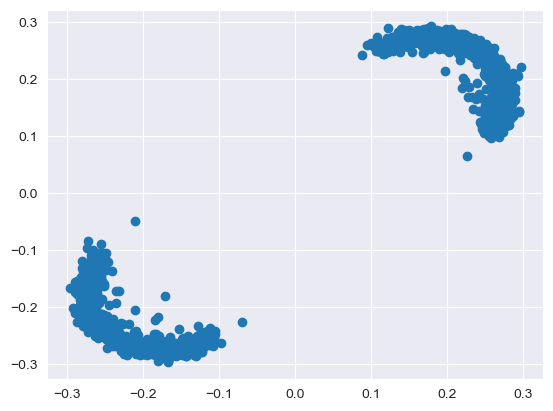

In [19]:
plt.scatter(samples[:, 0], samples[:, 1])
plt.show()